# <center>IResNet [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from utils.NF_base import *
from utils.matrix_utils import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class Lip_mlp(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers, coeff=.97, n_power_iter=5):
        """
            coeff: desired Lipschitz constant
        """
        super().__init__()
        self.coeff = coeff
        self.n_power_iter = n_power_iter
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.utils.spectral_norm(nn.Linear(d_in,nh),n_power_iterations=n_power_iter))
        for i in range(n_layers):
            self.layers.append(nn.utils.spectral_norm(nn.Linear(nh,nh),n_power_iterations=n_power_iter))
        self.layers.append(nn.utils.spectral_norm(nn.Linear(nh,d_out),n_power_iterations=n_power_iter))

        self.elu = nn.ELU()

    def forward(self, x):
        for layer in self.layers:
            x = self.elu(layer(x)) # to be differentiable everywhere
        return x


**IResNet:**
\begin{equation*}
    x = T(z) = z+g(z)
\end{equation*}
with $g$ a Lipschitz function such that Lip($g$)$<1$.

The Jacobian is:
\begin{equation*}
    J_T(z) = I+J_g(z)
\end{equation*}
And its determinant is:
\begin{align*}
    \log|\det J_T(z)| &= \log \det J_T(z) \\
    &= \mathrm{Tr}(\log J_T(z)) \\
    &= \mathrm{Tr}(\log(I+J_T(z))) \\
    &= \sum_{k=1}^{\infty} (-1)^{k+1} \frac{\mathrm{Tr}(J_g^k)}{k} \\
    &= \sum_{k=1}^{\infty} (-1)^{k+1} \frac{1}{nk}\sum_{\ell=1}^n v_\ell^T J_g^k v_\ell \text{ using the Hutchinson's trace estimator and }v_\ell\sim\mathcal{N}(0,I)
\end{align*}

There is no analytical inverse. They use instead a fixed point algorithm:
- $x_0=y$
- For $i=0...n$ do
    - $x^{i+1}=y-g(x^i)$

To enforce Lipschitz constraint, they use the power iteration algorithm (cf [2]).

In [4]:
class iResNet(nn.Module):
    def __init__(self,d,resBlock,num_series_term=10,num_trace_samples=10):
        super().__init__()
        self.d = d
        self.resBlock = resBlock
        self.num_series_term = num_series_term
        self.num_trace_samples = num_trace_samples
    
    def forward(self, x):
        gx = self.resBlock(x)
        z = gx+x
        if self.d>5:
            log_det = power_series_matrix_logarithm_trace(gx, x, self.num_series_term, self.num_trace_samples)
        else:
            log_det = power_series_full_jac_exact_trace(gx, x, self.num_series_term)
        return z, log_det
    
    def backward(self, z, num_iter=100):
        """
            fixed point iteration
        """
        x = z
        for i in range(num_iter):
            x = z-self.resBlock(x)

        # x.requires_grad = True
        # gx = self.resBlock(x)
        # y = gx+x
        # log_det = power_series_matrix_logarithm_trace(gx, x, self.num_series_term, self.num_trace_samples)
        
        return x, torch.zeros(x.size(0),device=device) # log_det # we do not care about this det for now

## Moons

In [8]:
def train_moons(model, n_epochs=10001):
    d = 2
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32,requires_grad=True).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5, 100, requires_grad=True)
            yline = torch.linspace(-.75, 1.25, 100, requires_grad=True)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)
            xy, log_s = model(xyinput.to(device))

            with torch.no_grad():
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)

                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()
                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.detach().cpu().numpy(), ygrid.detach().cpu().numpy(), zgrid.detach().cpu().numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [9]:
def loss(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [10]:
d = 2

mlps = [Lip_mlp(d,64,d,3) for k in range(10)]

flows = []
for i in range(10):
    flows.append(iResNet(d,mlps[i]))
    flows.append(ActNorm(dim=d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  128060


0 2.00071382522583
100 1.9313457012176514
200 1.8335206508636475
300 1.7365142107009888
400 1.6615843772888184


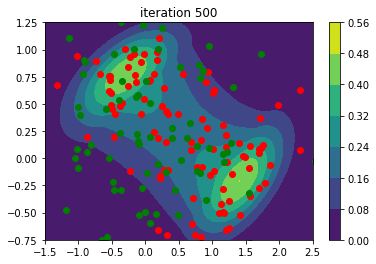

500 1.611636757850647
600 1.6048307418823242
700 1.4987943172454834
800 1.5009486675262451
900 1.4498480558395386


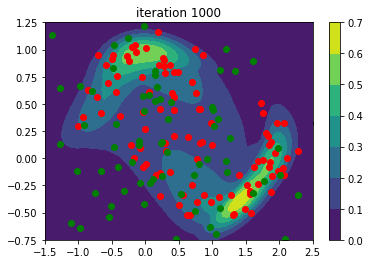

1000 1.4730448722839355
1100 1.3890986442565918
1200 1.384744644165039
1300 1.2725211381912231
1400 1.2989938259124756


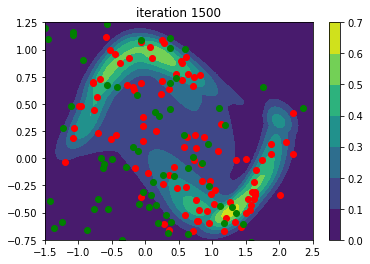

1500 1.3326798677444458
1600 1.3291425704956055
1700 1.300525188446045
1800 1.2794759273529053
1900 1.246628761291504


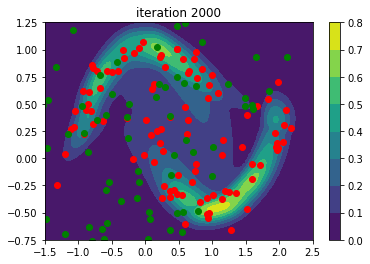

2000 1.2521227598190308
2100 1.2812814712524414
2200 1.1653761863708496
2300 1.2074191570281982
2400 1.1971224546432495


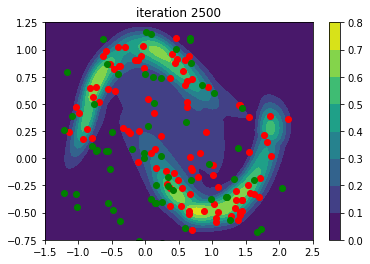

2500 1.1864231824874878
2600 1.1836013793945312
2700 1.2004408836364746
2800 1.1773878335952759
2900 1.2655503749847412


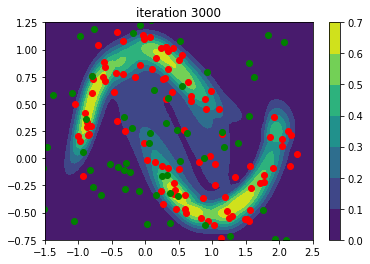

3000 1.156821370124817
3100 1.16570246219635
3200 1.10004723072052
3300 1.049656629562378
3400 1.2065010070800781


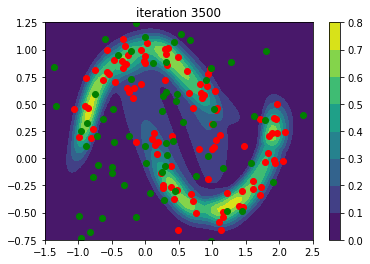

3500 1.1116266250610352
3600 1.0423853397369385
3700 1.1755616664886475
3800 1.075287938117981
3900 1.0266141891479492


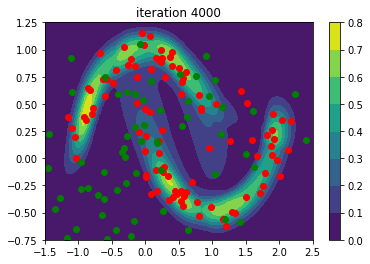

4000 1.0971145629882812
4100 1.1012775897979736
4200 1.0925676822662354
4300 1.0865039825439453
4400 1.1610393524169922


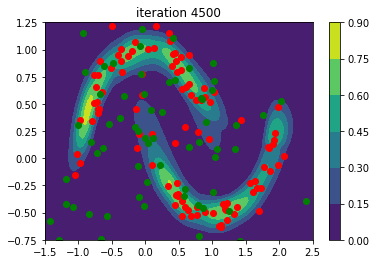

4500 1.1006760597229004
4600 1.0563836097717285
4700 1.0104072093963623
4800 1.1110717058181763
4900 1.1571176052093506


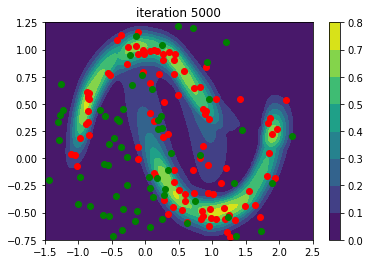

5000 1.0836713314056396
5100 1.0900036096572876
5200 1.0400842428207397
5300 1.0302379131317139
5400 1.0204427242279053


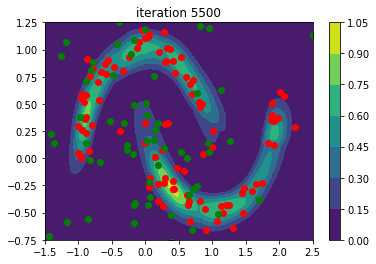

5500 1.1377990245819092
5600 0.9800713062286377
5700 0.9536848068237305
5800 1.0623221397399902
5900 1.0219146013259888


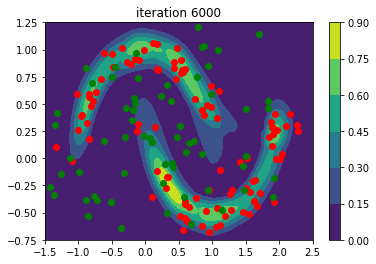

6000 1.0592237710952759
6100 1.0386422872543335
6200 1.068931221961975
6300 1.041957139968872
6400 1.0273743867874146


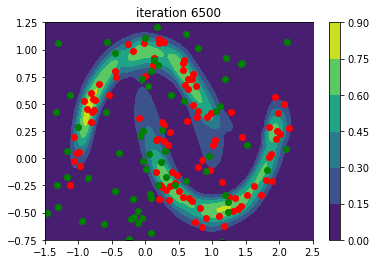

6500 1.0353760719299316
6600 1.0579934120178223
6700 1.0307376384735107
6800 1.0670075416564941
6900 1.1127371788024902


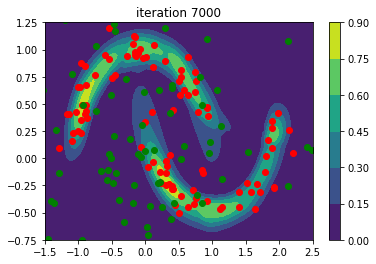

7000 1.0703203678131104
7100 0.9799269437789917
7200 0.9815515279769897
7300 0.9930596351623535
7400 0.9972379207611084


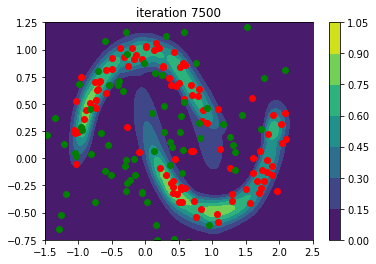

7500 1.0809003114700317
7600 1.0209224224090576
7700 1.1164942979812622
7800 1.0208224058151245
7900 0.9542772769927979


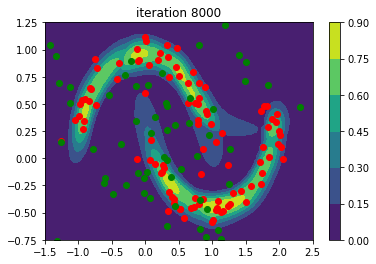

8000 1.0497426986694336
8100 0.966970682144165
8200 1.061220645904541
8300 1.0842363834381104
8400 1.0194506645202637


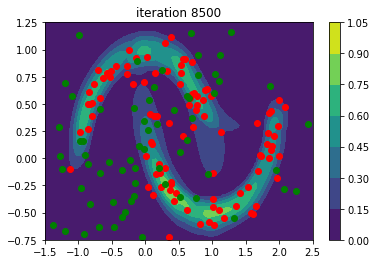

8500 1.0110303163528442
8600 1.1516540050506592
8700 0.9628684520721436
8800 1.0250136852264404
8900 1.0387461185455322


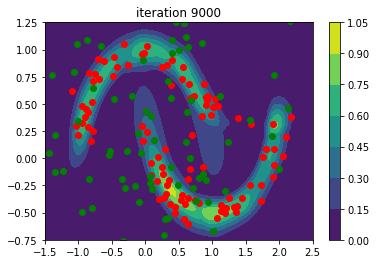

9000 0.9891960620880127
9100 0.9672356843948364
9200 1.0118346214294434
9300 1.0309337377548218
9400 1.0177865028381348


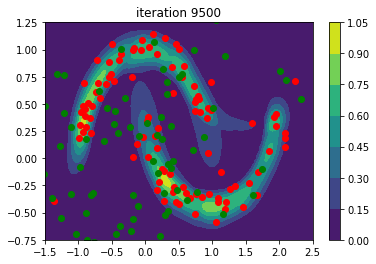

9500 1.0507149696350098
9600 0.9652899503707886
9700 0.9907935857772827
9800 0.9398598670959473
9900 0.9916210174560547


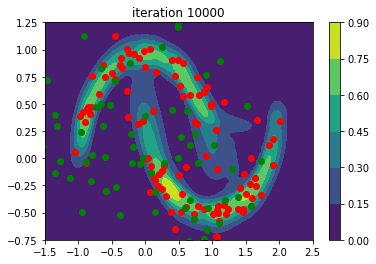

10000 1.0394521951675415


In [11]:
train_loss = train_moons(model, n_epochs=10001)

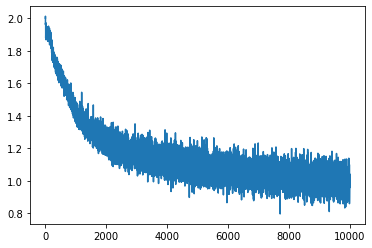

In [12]:
plt.plot(train_loss)
plt.show()

## References

<a id="reference1"></a>

[1] Behrmann, J., Grathwohl, W., Chen, R. T. Q., Duvenaud, D., & Jacobsen, J-H. Invertible Residual Networks. arXiv preprint arXiv:1811.00995. (2018). [link](https://arxiv.org/abs/1811.00995 )

[2] Gouk, H., Frank, E., Pfahringer, B,. & Cree, M. J. Regularisation of Neural Netwrks by Enforcing Lipschitz Continuity. (2020). [link](https://arxiv.org/abs/1804.04368 )